In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

# Macro Features

Chakravorty et al, 2018 에서 사용된 macro feature 14개를 만듭니다.

In [3]:
df = pd.DataFrame()
path = '/Users/mac/Desktop/PycharmProjects/TAADL/input/macro'
for root, dirs, files in os.walk(path, topdown=False):
    for name in files:
        print(name)
        if name == '.DS_Store':
            pass
        else:
            dataname = name.split('.')[0]
            exec(f'{dataname} = pd.read_csv(os.path.join(root, name),index_col="Date")')
            exec(f'{dataname}.index = pd.to_datetime({dataname}.index)')
            exec(f'df = pd.concat([df, {dataname}.iloc[:,:1]],axis=1)')
            

Russell2000.csv
US10Y.csv
Gold.csv
.DS_Store
USPAY.csv
USCPI.csv
Copper.csv
US3M.csv
DJIA.csv
US2Y.csv
USGDP.csv
JPY.csv
Oil.csv
SP500.csv


In [4]:
# cut past nan values and ffill values 
df = df.loc['2001-01-01':,:].ffill().dropna(axis=0)

In [5]:
# feature engineering
macro_data = df.loc[:,['JPY','US10Y','Gold','Copper','Oil','SP500','US_Pay','US_GDP','US_CPI']]
macro_data['10Y-2YSpread']  = df['US10Y'] - df['US2Y']
macro_data['2Y-3MSpread']   = df['US2Y'] - df['US3M']
macro_data['Cop/Gold']      = df['Copper'].div(df['Gold'])
macro_data['SP500/DJIA']    = df['SP500'].div(df['DJIA'])
macro_data['SP500/Rus2000'] = df['SP500'].div(df['Russell2000'])

# ETF Features

In [6]:
df_etf = pd.DataFrame()
etf_names = []
path = '/Users/mac/Desktop/PycharmProjects/TAADL/input/blackrock_etf'
for root, dirs, files in os.walk(path, topdown=False):
    for name in files:
        if name == '.DS_Store':
            pass
        else:
            dataname = name.split('.')[0]
            etf_names.append(dataname)
            exec(f'{dataname} = pd.read_csv(os.path.join(root, name),index_col="Date")')
            exec(f'{dataname}.index = pd.to_datetime({dataname}.index)')
            exec(f'df_etf = pd.concat([df_etf, {dataname}[["Adj Close"]]],axis=1)')

df_etf.columns = etf_names
df_etf = df_etf.dropna(axis=0)

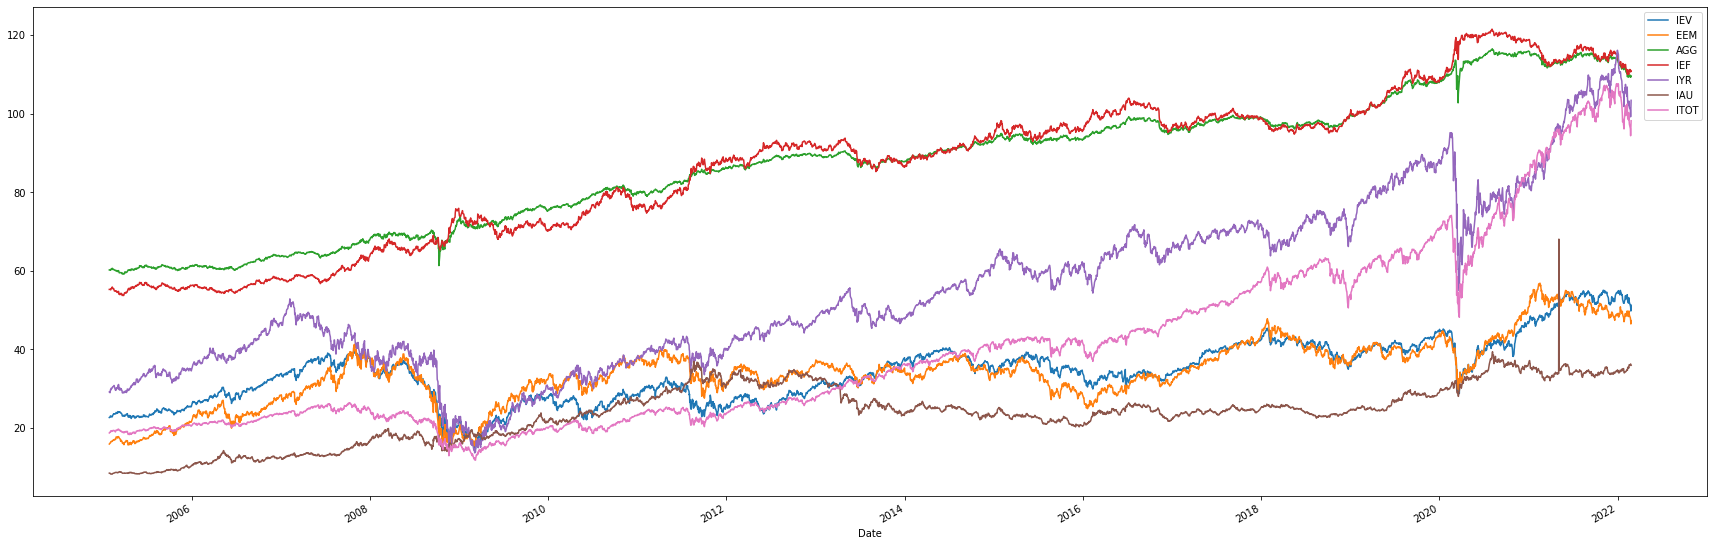

In [7]:
df_etf.plot(figsize=(30,10))
df_etf.to_csv('/Users/mac/Desktop/PycharmProjects/TAADL/input/prices.csv')

In [8]:
df_etf.loc['2021-05','IAU'] = 33.8800001 # outlier

<AxesSubplot:xlabel='Date'>

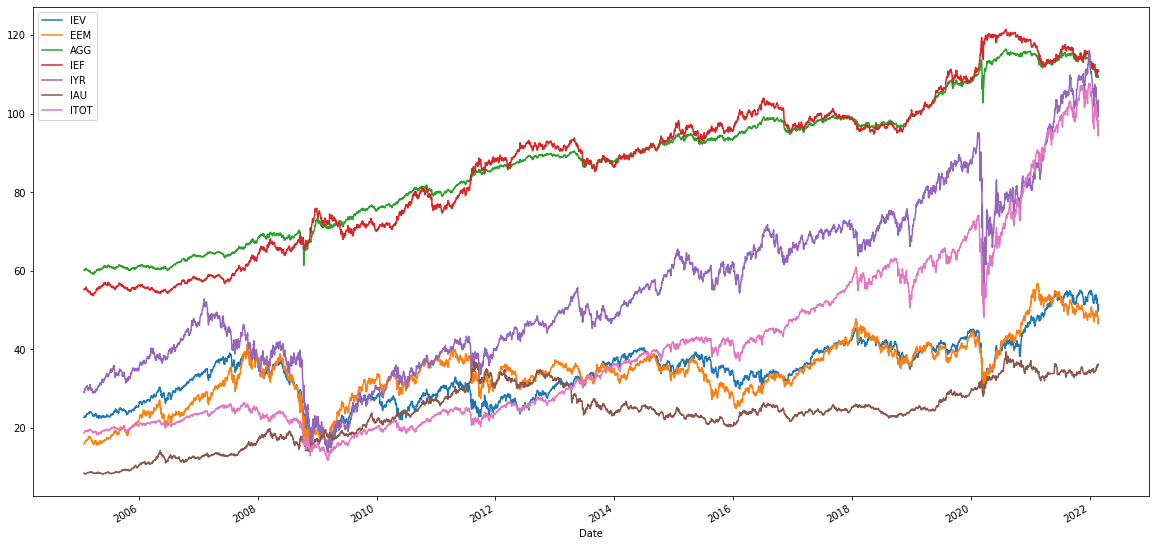

In [9]:
df_etf.plot(figsize=(20,10))

논문 Chakravorty et al.2018 의 내용을 토대로 각 자산의 기간별 과거수익률을 구합니다. price related feature 는 총 28개(자산 7개)입니다.

In [27]:
# Now create features related to price data
df_etf_20  = df_etf/df_etf.shift(20) - 1
df_etf_60  = df_etf/df_etf.shift(60) - 1
df_etf_126 = df_etf/df_etf.shift(126) - 1
df_etf_252 = df_etf/df_etf.shift(252) - 1

# rename columns that matches 
df_etf_20  = df_etf_20.add_suffix('_ret020') # month 
df_etf_60  = df_etf_60.add_suffix('_ret060') # 3months
df_etf_126 = df_etf_126.add_suffix('_ret126') # 6months
df_etf_252 = df_etf_252.add_suffix('_ret252') # 1 year

# concatenate all etf return features
price_data = pd.concat([df_etf_20, df_etf_60, df_etf_126, df_etf_252],axis=1)
price_data = price_data.sort_index(axis=1)

concat 후 저장해줍니다.

In [29]:
macro_data.index = pd.to_datetime(macro_data.index)
price_data.index = pd.to_datetime(price_data.index)

# concatenate price and macro features
feature = pd.concat([price_data, macro_data.loc[price_data.loc[:'2022-02-24'].index,:]], axis=1)
feature = feature.dropna(axis=0)

In [30]:
feature.to_csv('/Users/mac/Desktop/PycharmProjects/TAADL/input/features.csv')
feature.head()

,AGG_ret020,AGG_ret060,AGG_ret126,AGG_ret252,EEM_ret020,EEM_ret060,EEM_ret126,EEM_ret252,IAU_ret020,IAU_ret060,...,Oil,SP500,US_Pay,US_GDP,US_CPI,10Y-2YSpread,2Y-3MSpread,Cop/Gold,SP500/DJIA,SP500/Rus2000
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-30,0.000398,0.013977,0.006620,0.015584,0.133862,0.251392,0.313068,0.532587,0.100194,0.240874,...,68.35,1285.19,135149.0,1.012465,3.415659,0.020,0.075,0.003950,0.117908,1.755197
2006-01-31,-0.000597,0.015094,0.007405,0.017071,0.141983,0.240474,0.300471,0.522636,0.097816,0.231353,...,67.92,1280.08,135429.0,1.012465,3.985317,-0.009,0.074,0.003917,0.117818,1.751447
2006-02-01,-0.003876,0.015727,0.006779,0.013160,0.100273,0.238501,0.277171,0.508954,0.068032,0.236510,...,66.56,1282.46,135429.0,1.012465,3.985317,-0.025,0.137,0.003967,0.117077,1.749127
2006-02-02,-0.005549,0.015418,0.004216,0.013082,0.062351,0.209156,0.247460,0.465523,0.070718,0.252304,...,64.68,1270.84,135429.0,1.012465,3.985317,-0.032,0.141,0.004049,0.117107,1.727906
2006-02-03,-0.002762,0.018161,0.008020,0.017206,0.042542,0.191776,0.241351,0.447009,0.080596,0.234024,...,65.37,1264.03,135429.0,1.012465,3.985317,-0.050,0.127,0.004085,0.117109,1.740489
